# 01 -  Introduction to OpenQAOA: An example workflow

This section provides a walkthrough of a simple example workflow, and is intended as a quick introduction to the functionalities of the OpenQAOA library. More focused examples are provided in other sections of the documentation.

The QAOA workflow can be divided in four simple steps:
- Problem definition: Define your optimization problem here, either by: 
    - using pre-defined problem classes or,
    - supplying your own QUBO
- Model building: 
    - Build the QAOA circuit with the available configurations
    - Choose the backend (device) to run the circuit
    - Choose the properties of the classical optimizer
- Compile model and optimize: 
    - Compile the model by passing the problem defined in step-1
    - Execute `model.optimize()` to run the optimization process
- Extract results
    - Run `model.results` to obtain information on the optimization run 

### Begin by importing necessary modules

In [1]:
#some regular python libraries
import matplotlib.pyplot as plt
from pprint import pprint
import networkx as nx

# The OpenQAOA imports
from openqaoa import QAOA, create_device
from openqaoa.problems import MaximumCut
from openqaoa.utilities import plot_graph

### Step 1: Create a problem instance
We begin by creating a problem instance for a simple MaximumCut problem for a random graph created using the python `networkx` module. MaximumCut is a go-to problem to demonstrate QAOA in action.

For this, we first:
- create a random graph using the `networkx` module
- using the MaximumCut problem class, we translate into the QUBO formalism to optimize with QAOA

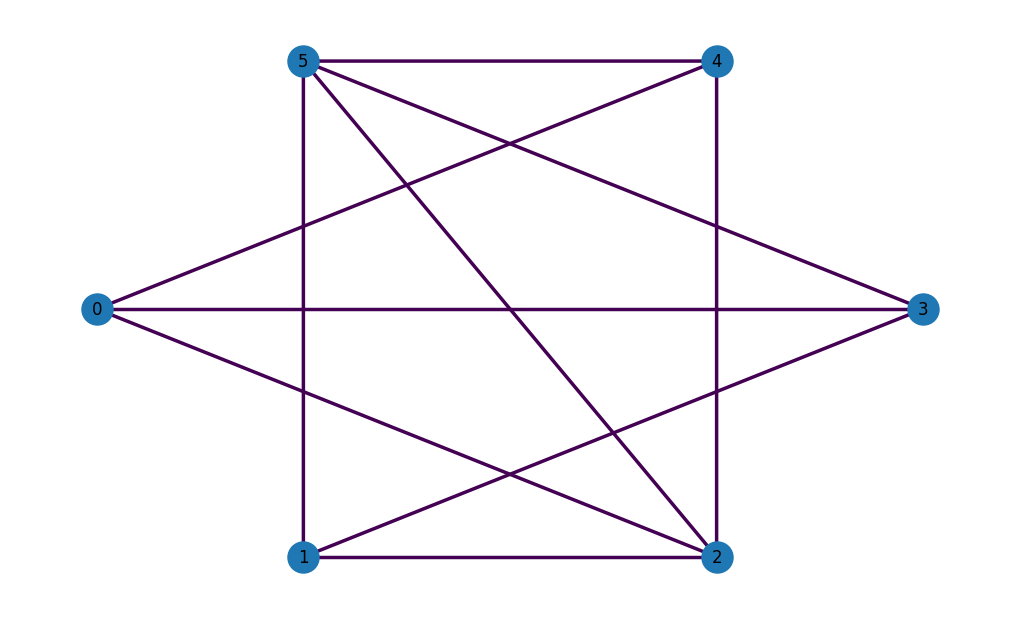

In [2]:
g = nx.generators.fast_gnp_random_graph(n=6, p=0.6, seed=42)

plot_graph(g)

We can then conveniently obtain the Quadratic Unconstrained Binary Optimization (QUBO) through the OpenQAOA built in problem clasess. This is a two stepo process

In [3]:
# Instantiate the problem via the MaximumCut class
maxcut_prob = MaximumCut(g)

# The property `qubo` translates the problem into a binary Qubo problem. 
# The binary values can be access via the `asdict()` method.
maxcut_qubo = maxcut_prob.qubo

In [4]:
pprint(maxcut_qubo.asdict())

{'constant': 0,
 'metadata': {},
 'n': 6,
 'problem_instance': {'G': {'directed': False,
                            'graph': {},
                            'links': [{'source': 0, 'target': 2},
                                      {'source': 0, 'target': 3},
                                      {'source': 0, 'target': 4},
                                      {'source': 1, 'target': 2},
                                      {'source': 1, 'target': 3},
                                      {'source': 1, 'target': 5},
                                      {'source': 2, 'target': 4},
                                      {'source': 2, 'target': 5},
                                      {'source': 3, 'target': 5},
                                      {'source': 4, 'target': 5}],
                            'multigraph': False,
                            'nodes': [{'id': 0},
                                      {'id': 1},
                                      {'id': 2},
             

### Extract the exact solution for a small enough problem



We can obtain the exact solution to the problem by using the `ground_state_hamiltonian()` moethod. Note that it solves the problem entirely classically via a brute force search! 

In [5]:
from openqaoa.utilities import ground_state_hamiltonian

In [6]:
# Extract the hamiltonian from the qubo problem
hamiltonian = maxcut_qubo.hamiltonian

# Obtained the exact solution
energy, configuration = ground_state_hamiltonian(hamiltonian)

print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -6.0, Solution: ['001110', '110001']


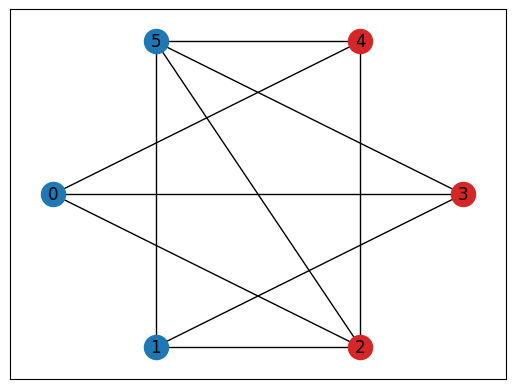

In [7]:
#plot the solution on graph
positions = {0: [-2, 0], 1: [-1,-1], 2: [1, -1], 3: [2,0], 4: [1,1], 5: [-1,1]}

nx.draw_networkx_nodes(g, positions, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, positions, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, positions)
nx.draw_networkx_labels(g, positions)
plt.show()

### Step 2: Build the QAOA model
 - Initialize the model (with default parameters)
 - Optionally set the following properties for the model
     - `model.set_device(...)`: Set the device
         - The device properties include the location of the device `[local, qcs, ibmq]` and the device name. Full list of devices available at              `openqaoa.workflows.parameters.qaoa_parameters.ALLOWED_DEVICES`
     - `model.set_circuit_properties(...)`: Sets the circuit properties. Mainly used for:
         - `p`: the number of layers
         - `param_type`: the desired parameterisation to be chosen between `['standard', 'extended', 'fourier', annealing]`
         - `init_type`: the initialisation strategy for param_type. To be chosen between `['ramp', 'random', 'custom']`
     - `model.set_backend_properties(...)`
     - `model.set_classical_optimizer(...)`


    
For more details on the configurable properties, please refer to the documentation

In [8]:
# initialize model with default configurations
q = QAOA()

In [9]:
# optionally configure the following properties of the model

# device
vectorized_device = create_device(location='local', name='vectorized')
q.set_device(vectorized_device)

# circuit properties
q.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

### Step 3: Compile and Optimize

- Once the QAOA model is configured, we need to compile it. **Compilation is necessary** because the QAOA solver has to interact with the problem in to be able to create the underlying QAOA circuit.
- The problem is ready to be optimized now. The user can call `model.optimize()` to initiate the optimization loop. 

In [10]:
q.compile(maxcut_qubo) 

In [11]:
q.optimize()

### Step 4: Understanding the OpenQAOA result object

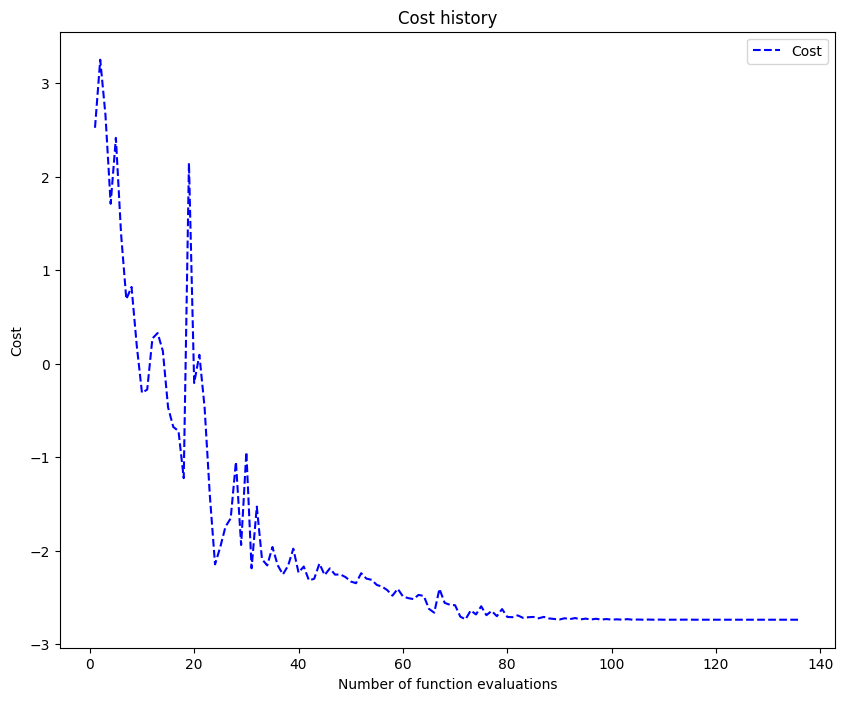

In [12]:
# print the cost history
q.result.plot_cost()

In [13]:
# prints a large output (commented by default)
# pprint(opt_results.intermediate)

In [14]:
pprint(q.result.optimized)

{'angles': [3.182067280401, 0.333197289626, 2.2571092274, 1.147694762102],
 'cost': -2.738347560584,
 'eval_number': 129,
 'job_id': 'd69a0f6c-831a-4711-8099-be0841414927',
 'measurement_outcomes': array([-0.01248848-0.00629593j, -0.02626972-0.05357992j,
       -0.05233306-0.01571863j, -0.05312218+0.08180536j,
       -0.02711295+0.00453362j, -0.00997301+0.063899j  ,
       -0.01259635+0.08600245j, -0.05596609+0.19211106j,
       -0.02626972-0.05357992j, -0.00870695+0.03017493j,
       -0.00133928+0.03025759j,  0.00974004+0.13115789j,
       -0.12549215+0.13164363j, -0.04396364+0.15953553j,
       -0.0301905 +0.13577789j, -0.01259635+0.08600245j,
       -0.05233306-0.01571863j, -0.00133928+0.03025759j,
       -0.05822591+0.10313427j, -0.1225332 +0.18690302j,
       -0.01133792+0.06700783j,  0.0512402 +0.07284756j,
       -0.04396364+0.15953553j, -0.00997301+0.063899j  ,
       -0.05312218+0.08180536j,  0.00974004+0.13115789j,
       -0.1225332 +0.18690302j, -0.05034312+0.12621829j,
    

We can also check the associated bit string distribution:

states kept: 40


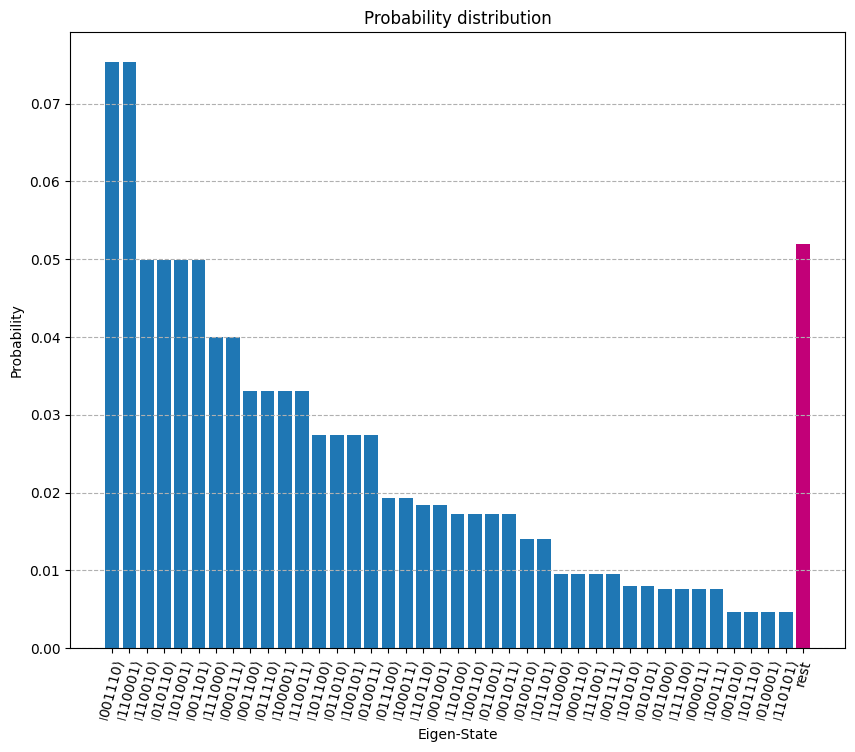

In [15]:
q.result.plot_probabilities()

### Visualising the result

As before, we can now check the solution to the problem

In [16]:
q.result.most_probable_states

{'solutions_bitstrings': ['001110', '110001'], 'bitstring_energy': -6.0}

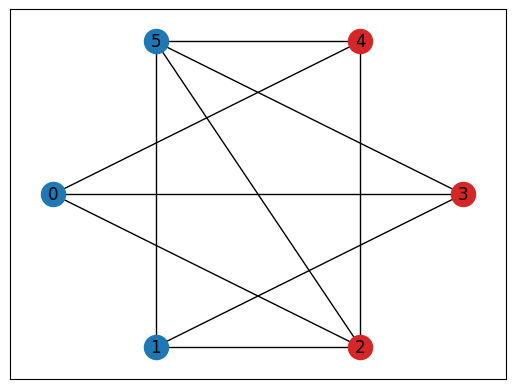

In [17]:
#plot the solution on graph
oq_solution  = q.result.most_probable_states['solutions_bitstrings']


nx.draw_networkx_nodes(g, positions, nodelist=[idx for idx,bit in enumerate(oq_solution[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, positions, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, positions)
nx.draw_networkx_labels(g, positions)
plt.show()